In [9]:
import scanpy as sc
import sys
sys.path.append(r"D:\Scunpair_Project\Diagonal-integration")
import mycode
import pandas as pd
adata_RNA = sc.read_h5ad(r"D:\Scunpair_Project\Dataset\Yao-2021\Yao-2021-RNA.h5ad")
adata_ATAC = sc.read_h5ad(r"D:\Scunpair_Project\Dataset\Yao-2021\Yao-2021-FRAGS2RNA.h5ad")

In [10]:
# 取交集基因并对齐
cm_genes = sorted(list(set(adata_ATAC.var_names) & set(adata_RNA.var_names)))
adata_RNA = adata_RNA[:, cm_genes]
adata_ATAC = adata_ATAC[:, cm_genes]

# 计算高变基因
sc.pp.highly_variable_genes(adata_RNA, flavor='seurat_v3', n_top_genes=1000)
sc.pp.highly_variable_genes(adata_ATAC, flavor='seurat_v3', n_top_genes=1000)

# 取共同的高变基因
shared_genes = adata_RNA.var_names[adata_RNA.var.highly_variable | adata_ATAC.var.highly_variable]
shared_genes = list(shared_genes)

adata_RNA = adata_RNA[:,shared_genes].copy()
adata_ATAC = adata_ATAC[:,shared_genes].copy()

sc.pp.normalize_total(adata_RNA)
sc.pp.log1p(adata_RNA)

sc.pp.normalize_total(adata_ATAC)
sc.pp.log1p(adata_ATAC)

c:\Users\Administrator\miniconda3\envs\mycode\lib\site-packages\scanpy\preprocessing\_highly_variable_genes.py:174: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns["hvg"] = {"flavor": flavor}
c:\Users\Administrator\miniconda3\envs\mycode\lib\site-packages\scanpy\preprocessing\_highly_variable_genes.py:174: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns["hvg"] = {"flavor": flavor}


In [11]:
import mycode
sc.pp.scale(adata_RNA, max_value=10)
sc.pp.scale(adata_ATAC, max_value=10)
#mycode.utils.batch_scale(adata_RNA,method='standard')
#mycode.utils.batch_scale(adata_ATAC,method='standard')

c:\Users\Administrator\miniconda3\envs\mycode\lib\functools.py:889: UserWarning: zero-centering a sparse array/matrix densifies it.
  return dispatch(args[0].__class__)(*args, **kw)
c:\Users\Administrator\miniconda3\envs\mycode\lib\functools.py:889: UserWarning: zero-centering a sparse array/matrix densifies it.
  return dispatch(args[0].__class__)(*args, **kw)


In [12]:
model = mycode.Model(adata_RNA, adata_ATAC, batch_size=500, 
                           training_steps=10001, seed=1234, celltype_col='cell_type',source_col=None,
                            n_latent=16, lambdaRecon = 10.0, lambdaLA = 10.0, loss_type='MSE',
                            lambdaAlign = 1.0, lambdamGAN = 1.0, lambdabGAN = 0.0, n_KNN = 30, lambdaGeo=0.5, mode = 'strong', use_prior = True, link_feat_num=len(shared_genes))

In [13]:
model.train()
model.eval()

Training started at: Tue Sep 30 16:41:44 2025
Step 0 | loss_Recon: 17.4649 | loss_LA: 42.8565 | loss_Align: 0.9258 | loss_Geo: 0.4306 | loss_mGAN vs loss_mDis: -1.3861 vs 1.3878 | loss_bGAN vs loss_bDis: -0.0000 vs 0.0000
Step 1000 | loss_Recon: 14.0611 | loss_LA: 0.0644 | loss_Align: 0.0386 | loss_Geo: 0.0208 | loss_mGAN vs loss_mDis: -1.3396 vs 1.3495 | loss_bGAN vs loss_bDis: -0.0000 vs 0.0000
Step 2000 | loss_Recon: 13.7885 | loss_LA: 0.0452 | loss_Align: 0.0351 | loss_Geo: 0.0191 | loss_mGAN vs loss_mDis: -1.3216 vs 1.3314 | loss_bGAN vs loss_bDis: -0.0000 vs 0.0000
Step 3000 | loss_Recon: 13.6004 | loss_LA: 0.0344 | loss_Align: 0.0280 | loss_Geo: 0.0144 | loss_mGAN vs loss_mDis: -1.3488 vs 1.3528 | loss_bGAN vs loss_bDis: -0.0000 vs 0.0000
Step 4000 | loss_Recon: 13.5031 | loss_LA: 0.0368 | loss_Align: 0.0299 | loss_Geo: 0.0160 | loss_mGAN vs loss_mDis: -1.3472 vs 1.3502 | loss_bGAN vs loss_bDis: -0.0000 vs 0.0000
Step 5000 | loss_Recon: 13.5938 | loss_LA: 0.0319 | loss_Align: 0.

In [14]:
import anndata as ad
import pandas as pd
adata_integrated = ad.AnnData(X=model.latent)
adata_integrated.obs = pd.concat([adata_RNA.obs, adata_ATAC.obs])
adata_integrated.obs['modality'] = ['RNA'] * adata_RNA.shape[0] + ['ATAC'] * adata_ATAC.shape[0]

In [15]:
sc.pp.neighbors(adata_integrated)
sc.tl.umap(adata_integrated, min_dist=0.3)

bathsize=500

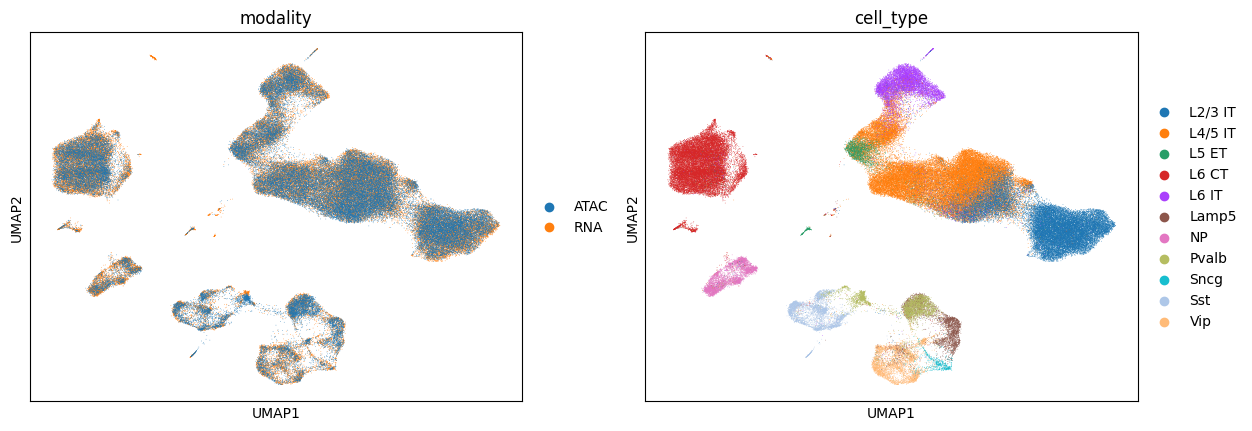

In [16]:
sc.pl.umap(adata_integrated, color=['modality','cell_type'])

batchsize=128

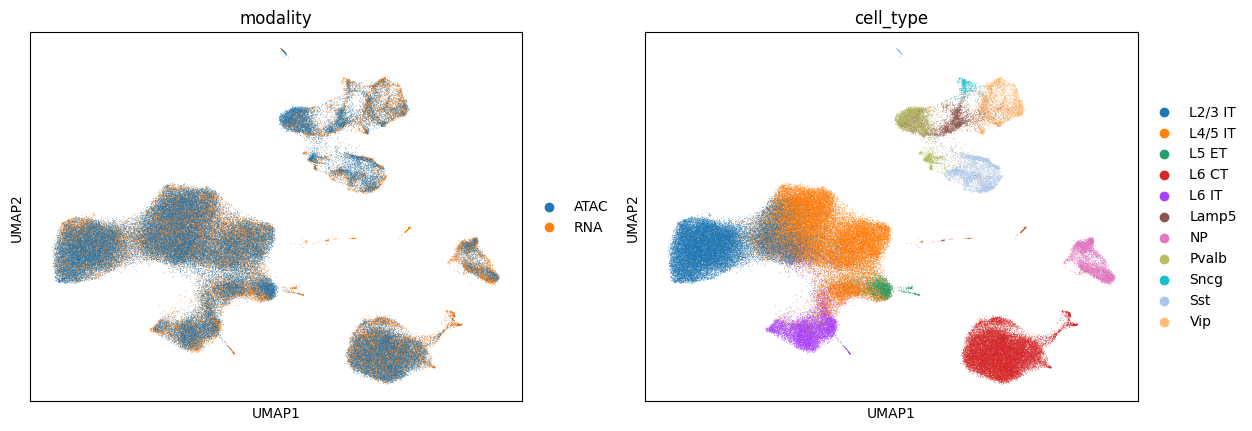

In [8]:
sc.pl.umap(adata_integrated, color=['modality','cell_type'])

In [9]:
import numpy as np
sc.pp.pca(adata_RNA)
sc.pp.pca(adata_ATAC)
X = model.latent
y = np.concatenate([adata_RNA.obsm['X_pca'], adata_ATAC.obsm['X_pca']], axis=0)
ct = pd.concat([adata_RNA.obs['cell_type'], adata_ATAC.obs['cell_type']]).to_numpy()
batch = np.array(['RNA']*adata_RNA.shape[0] + ['ATAC']*adata_ATAC.shape[0])
map_score = mycode.metrics.mean_average_precision(X, ct)
asw_celltype = mycode.metrics.avg_silhouette_width(X, ct)
nc = mycode.metrics.neighbor_conservation(X, y, batch)
asw_batch = mycode.metrics.avg_silhouette_width_batch(X, batch, ct)
sas = mycode.metrics.seurat_alignment_score(X, batch)
gc = mycode.metrics.graph_connectivity(X, batch)

print("MAP:", map_score)
print("ASW_celltype:", asw_celltype)
print("NC:", nc)
print("ASW_batch:", asw_batch)
print("SAS:", sas)
print("GC:", gc)

c:\Users\Administrator\miniconda3\envs\mycode\lib\site-packages\anndata\_core\anndata.py:381: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(


MAP: 0.9280297099715352
ASW_celltype: 0.5869224518537521
NC: 0.3250414550717565
ASW_batch: 0.8978342413902283
SAS: 0.7382614719851457
GC: 0.9960241255900565


D:\Scunpair_Project\Diagonal-integration\mycode\metrics.py:326: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  counts = pd.value_counts(c)
